In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import warnings; warnings.simplefilter('ignore')

In [2]:
# Composite DP Mechanism (1) [https://github.com/CompositeDP/CompositeDP]

def float3f(num):
    return float(format(num, '.3f'))


def float2f(num):
    return float(format(num, '.2f'))


# Constraints

def LValue(ep, k, m, y):
    return (1 - k * m) / (2 * y)

def aValue(ep, k, m, y, Cp):
    return (2 * Cp - k * m ** 2) / (2 * k * m)

def checkConstraints(ep, k, m, y, Cp):
    if k <= 0:
        return -1
    if m <= 0:
        return -2
    if y <= 0:
        return -3

    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)

    if k * m >= 1:
        return -4
    if (Cp > k * m * (2 * L - m) / 2) or (Cp < -k * m * (2 * L - m) / 2):
        return -5
    if k > 1 - y:
        return -6
    if k > y * (np.e ** ep - 1):
        return -7
    
    return 0


# Mapping

def range_Cp_fun(ep, k, m, y):
    L = LValue(ep, k, m, y)
    return k * m * (2 * L - m)

def mapping_fromRealToL(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_value = (input_value - lower) * C - L

    return mapped_value

def mapping_inverse_fromLToReal(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_inverse_value = (input_value + L) / C + lower

    return mapped_inverse_value

def listmapping_inverse_fromLToReal(input_list, range_f, lower, ep, k, m, y):
    mapped_inverse_list = []
    for i in range(len(input_list)):
        tmp = mapping_inverse_fromLToReal(input_list[i], range_f, lower, ep, k, m, y)
        mapped_inverse_list.append(tmp)
    return mapped_inverse_list


# Parameter Optimization

def reduceRate(var1, var2):
    rate = (var1 - var2) / var1
    return float(rate)

def H1Rate(ep, k, m, y):
    L = LValue(ep, k, m, y)
    S1 = k*m; S2 = 2*L*y
    return float(S2 / S1)

def H2Rate(Cp, ep, k, m, y):
    L = LValue(ep, k, m, y)
    return 0.33333

def theory_var_fun(ep, k, m, y, Cp_assume):
    Cp = Cp_assume
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    variance = -Cp ** 2 + 2 * L ** 3 * y / 3 + a ** 2 * k * m + a * k * m ** 2 + k * m ** 3 / 3
    return float(variance)

def parameter_optimization(ep):
    step1 = 0.1
    step2 = 0.01
    step3 = 0.001
    k_best = 0
    m_best = 0
    y_best = 0
    reduceRate_best = -1000

    y_upper = 1
    k_upper = 1
    m_upper = 2

    # First round step1
    y_count = 0
    while (y_count < y_upper):
        k_count = 0
        while (k_count < k_upper):
            m_count = 0
            while (m_count <= m_upper):
                if y_count == 0:
                    m_count = m_count + step1
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step1
            k_count = k_count + step1
        y_count = y_count + step1

    # Second round step2
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.1
    else:
        y_count = y_best - step1
        y_count_end = y_best + step1
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.1
        else:
            k_count = k_best - step1
            k_count_end = k_best + step1
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.1
            else:
                m_count = m_best - step1
                m_count_end = m_best + step1
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step2
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step2
            k_count = k_count + step2
        y_count = y_count + step2

    # Third round step3
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.01
    else:
        y_count = y_best - step2
        y_count_end = y_best + step2
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.01
        else:
            k_count = k_best - step2
            k_count_end = k_best + step2
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.01
            else:
                m_count = m_best - step2
                m_count_end = m_best + step2
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step3
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step3
            k_count = k_count + step3
        y_count = y_count + step3

    return k_best, m_best, y_best


# Perturbation Mechanism

def PDF_fun(x, ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    P = 0
    if (x >= -L) and (x < a):
        P = y
    if (x >= a) and (x < a + m):
        P = y + k
    if (x >= a + m) and (x <= L):
        P = y
    return float3f(P)

def generate_perturbed_list(ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    t = (y + k) / np.e ** ep

    divid = 10000
    step = 2 * L / divid
    x_count = -L
    X_axis = []
    P_axis = []
    Perturbed_list = []

    while (x_count <= L):
        P_x = PDF_fun(x_count, ep, k, m, y, Cp)
        P_axis.append(P_x)
        X_axis.append(x_count)
        x_count = x_count + step

    for i in range(len(X_axis)):
        rp = P_axis[i]
        rp = int(rp * 1000)
        for j in range(rp):
            Perturbed_list.append(X_axis[i])

    random.shuffle(Perturbed_list)
    return Perturbed_list

def CDPM(ep, fd, range_f, lower):
    k_best, m_best, y_best = parameter_optimization(ep)
    Cp = mapping_fromRealToL(fd, range_f, lower, ep, k_best, m_best, y_best)
    O_perturbed = generate_perturbed_list(ep, k_best, m_best, y_best, Cp)
    Out_perturbed = listmapping_inverse_fromLToReal(O_perturbed, range_f, lower, ep, k_best, m_best, y_best)

    return Out_perturbed[0]

In [3]:
# Laplace Mechanism

def LM(epsilon, fx, sensitivity):
    z = np.random.laplace(0,sensitivity/epsilon,1)
    return fx+z

In [4]:
# Central Piecewise Mechanism for a numeric query

def eta(c,l,r):
    return (2/r)*c - (2*l+r)/r

def inverse_eta(z,l,r):
    return (r/2)*z + (2*l+r)/2

def CPM(epsilon, fx, l, r, sensitivity):
    # Mapping Step
    t = eta(fx,l,r)
    tild_sensitivity = (2/r)*sensitivity
    m = 0
    while(1):
        if m < 2/tild_sensitivity <= m+1:
            break
        else:
            m += 1
    
    # Perturbation Step
    A = tild_sensitivity*(math.exp(epsilon)*(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1))
    B = (1 + m*tild_sensitivity)*math.exp((m+1)*epsilon)
    U = epsilon/math.log((A + math.sqrt(A**2 + 4*B))/2)
    b = (7/8)*U #((m+3)/(m+4))*U
    
    q = (math.exp(epsilon/b)/(2*((math.exp(epsilon/b)+1)**2)*(math.exp(epsilon)-1)))*((math.exp(epsilon)-1)*(math.exp((m+1)*epsilon)-1)-tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*(m*math.exp((m+1)*epsilon)-(m+1)*math.exp(m*epsilon)+1))
    X = math.exp((m+1)*epsilon)/(2*q*(math.exp(epsilon/b)+1))
    Y = np.zeros(m+2)
    for j in range(1,m+2):
        Y[j] = (1/(2*q))*(math.exp(epsilon/b)/(math.exp(epsilon/b)+1))*(1+tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*((m+1-j)*math.exp(m*epsilon)-(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1)))
    D = X + Y[1]
    
    u = random.uniform(0,1)
    flag = 0
    if u < (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D):
        tt = random.uniform(-D,X*t-Y[1])
        flag = 1
    p = (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D)
    for j in range(1,m+1):
        p += (q/math.exp((m+1-j)*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t-Y[j],X*t-Y[j+1])
            flag = 1
    p += q*2*Y[m+1]
    if flag == 0 and u < p:
        tt = random.uniform(X*t-Y[m+1],X*t+Y[m+1])
        flag = 1
    for j in range(1,m+1):
        p += (q/math.exp(j*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t+Y[m+2-j],X*t+Y[m+1-j])
            flag = 1
    if flag == 0:
        tt = random.uniform(X*t+Y[1],D)
        flag = 1
    
    # Inverse Mapping
    p_fx = inverse_eta(tt,l,r)
    
    return p_fx

In [5]:
def EnhancedCPM(eps,k,m):
    nv = 1
    for j in range(1,k+1):
        nv *= (m[j]+2)
        
    v = np.zeros((nv,k+1))
    index = np.zeros((k+1,int(max(m))+2,int(nv)))
    n = np.zeros((k+1,int(max(m))+2))
    for i in range(nv):
        I = i
        for j in range(k-1):
            v[i][k-j] = I%(m[k-j]+2)
            index[k-j][int(v[i][k-j])][int(n[k-j][int(v[i][k-j])])] = i
            n[k-j][int(v[i][k-j])] += 1
            I = int(I/(m[k-j]+2))
        v[i][1] = I
        index[1][I][int(n[1][I])] = i
        n[1][I] += 1
    #print(v)
    #print(n)
    #print(index)
    
    tild_sensitivity = np.zeros(k+1)
    for j in range(1,k+1):
        tild_sensitivity[j] = 2/(m[j]+1)
        
    b = np.zeros(k+1)
    for j in range(1,k+1):
        A = tild_sensitivity[j]*(math.exp(eps[j])*(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1))
        B = (1 + m[j]*tild_sensitivity[j])*math.exp((m[j]+1)*eps[j])
        U = eps[j]/math.log((A + math.sqrt(A**2 + 4*B))/2)
        b[j] = ((m[j]+3)/(m[j]+4))*U
        
    X = np.zeros(k+1)
    Y = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        q = (math.exp(eps[j]/b[j])/(2*((math.exp(eps[j]/b[j])+1)**2)*(math.exp(eps[j])-1)))*((math.exp(eps[j])-1)*(math.exp((m[j]+1)*eps[j])-1)-tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*(m[j]*math.exp((m[j]+1)*eps[j])-(m[j]+1)*math.exp(m[j]*eps[j])+1))
        X[j] = math.exp((m[j]+1)*eps[j])/(2*q*(math.exp(eps[j]/b[j])+1))
        for i in range(1,m[j]+2):
            Y[j][i] = (1/(2*q))*(math.exp(eps[j]/b[j])/(math.exp(eps[j]/b[j])+1))*(1+tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*((m[j]+1-i)*math.exp(m[j]*eps[j])-(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1)))
        
    d = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        d[j][0] = 2*X[j]
        for i in range(1,m[j]+1):
            d[j][i] = 2*(Y[j][i]-Y[j][i+1])
        d[j][m[j]+1] = 2*Y[j][m[j]+1]
    #print(d)
    
    N = np.ones(nv)
    for i in range(nv):
        for j in range(1,k+1):
            N[i] *= d[j][int(v[i][j])]
    #print(N)
    
    p0 = np.ones(int(nv)+1)*(1/int(nv))
    p0[int(nv)] = math.exp(np.sum(eps))
    fun = lambda p: p[int(nv)]
    
    cons = ()
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(int(nv)))-1},)
    for i in range(1,k+1):
        cons = cons + ({'type': 'eq', 'fun': lambda p, i=i: np.sum(p[int(index[i][0][l])] for l in range(int(n[i][0]))) - 1/(math.exp(eps[i]/b[i])+1)},)
        for j in range(1,m[i]+1):
            cons = cons + ({'type': 'eq', 'fun': lambda p, i=i, j=j: np.sum(p[int(index[i][j][l])] for l in range(int(n[i][j]))) - tild_sensitivity[i]*(math.exp(j*eps[i])/(math.exp(eps[i]/b[i])+1))},)
    
    NV = nv
    NB = 0
    for i in range(1,k+1):
        NV = int(NV/(m[i]+2))
        NB += NV
        for j in range(int(nv)-NV):
            if v[j][i] != m[i]+1:
                cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[j+NV]/N[j+NV]) - (p[j]/N[j])},)
    #print(NV)
    #print(NB)
    
    for j in range(int(nv)-NB):
        flag = 1
        for i in range(1,k+1):
            if v[j][i] == m[i]+1:
                flag = 0
        if flag == 1:
            cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[int(nv)] - (p[j+NB]/N[j+NB])/(p[j]/N[j])},)
    
    
    bnds = [(0,1)]*(int(nv)+1)
    bnds[int(nv)] = (1,math.exp(np.sum(eps)))
    
    res = minimize(fun, p0, bounds=bnds, constraints=cons)
    #print(math.log(res.fun))
    #print(res)
    
    return res.fun, res.x

In [6]:
def SubOptimal(eps,m,p_eps1):
    k = 2
    
    tild_sensitivity = np.zeros(k+1)
    for j in range(1,k+1):
        tild_sensitivity[j] = 2/(m[j]+1)
        
    b = np.zeros(k+1)
    for j in range(1,k+1):
        A = tild_sensitivity[j]*(math.exp(eps[j])*(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1))
        B = (1 + m[j]*tild_sensitivity[j])*math.exp((m[j]+1)*eps[j])
        U = eps[j]/math.log((A + math.sqrt(A**2 + 4*B))/2)
        b[j] = ((m[j]+3)/(m[j]+4))*U
        
    X = np.zeros(k+1)
    Y = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        q = (math.exp(eps[j]/b[j])/(2*((math.exp(eps[j]/b[j])+1)**2)*(math.exp(eps[j])-1)))*((math.exp(eps[j])-1)*(math.exp((m[j]+1)*eps[j])-1)-tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*(m[j]*math.exp((m[j]+1)*eps[j])-(m[j]+1)*math.exp(m[j]*eps[j])+1))
        X[j] = math.exp((m[j]+1)*eps[j])/(2*q*(math.exp(eps[j]/b[j])+1))
        for i in range(1,m[j]+2):
            Y[j][i] = (1/(2*q))*(math.exp(eps[j]/b[j])/(math.exp(eps[j]/b[j])+1))*(1+tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*((m[j]+1-i)*math.exp(m[j]*eps[j])-(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1)))
        
    d = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        d[j][0] = 2*X[j]
        for i in range(1,m[j]+1):
            d[j][i] = 2*(Y[j][i]-Y[j][i+1])
        d[j][m[j]+1] = 2*Y[j][m[j]+1]
    #print(d)
    
    N = np.zeros((m[1]+2,m[2]+2))
    for i in range(m[1]+2):
        for j in range(m[2]+2):
            N[i][j] = d[1][i]*d[2][j]
    #print(N)
    
    p0 = np.ones(2*m[1]+2*m[2]+5)*(1/(2*m[1]+2*m[2]+4))
    p0[2*m[1]+2*m[2]+4] = math.exp(np.sum(eps))
    fun = lambda p: p[2*m[1]+2*m[2]+4]
    
    cons = ()
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(2*m[1]+2*m[2]+4)) + np.sum(p[m[1]+j]*(N[m[1]-i][j]/N[m[1]][j])*(1/math.exp(p_eps1*i)) for i in range(1,m[1]+1) for j in range(m[2])) - 1},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: p[0] + p[m[1]+m[2]+1] + np.sum(p[m[1]+j]*(N[0][j]/N[m[1]][j])*(1/math.exp(p_eps1*m[1])) for j in range(m[2])) - 1/(math.exp(eps[1]/b[1])+1)},)
    for i in range(1,m[1]):
        cons = cons + ({'type': 'eq', 'fun': lambda p, i=i: p[i] + p[m[1]+m[2]+1+i] + np.sum(p[m[1]+j]*(N[i][j]/N[m[1]][j])*(1/math.exp(p_eps1*(m[1]-i))) for j in range(m[2])) - tild_sensitivity[1]*(math.exp(i*eps[1])/(math.exp(eps[1]/b[1])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(m[1],m[1]+m[2]+1)) + p[2*m[1]+m[2]+1] - tild_sensitivity[1]*(math.exp(m[1]*eps[1])/(math.exp(eps[1]/b[1])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[m[1]]*(N[i][0]/N[m[1]][0])*(1/math.exp(p_eps1*(m[1]-i))) for i in range(m[1]+1)) + p[2*m[1]+m[2]+2] - 1/(math.exp(eps[2]/b[2])+1)},)
    for j in range(1,m[2]):
        cons = cons + ({'type': 'eq', 'fun': lambda p, j=j: np.sum(p[m[1]+j]*(N[i][j]/N[m[1]][j])*(1/math.exp(p_eps1*(m[1]-i))) for i in range(m[1]+1)) + p[2*m[1]+m[2]+2+j] - tild_sensitivity[2]*(math.exp(j*eps[2])/(math.exp(eps[2]/b[2])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(m[1])) + p[m[1]+m[2]] + p[2*m[1]+2*m[2]+2] - tild_sensitivity[2]*(math.exp(m[2]*eps[2])/(math.exp(eps[2]/b[2])+1))},)
    
    for i in range(m[1]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[i]/N[i][m[2]]) - (p[m[1]+m[2]-1]/N[m[1]][m[2]-1])*(1/math.exp(p_eps1*(m[1]-i)))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[m[1]+m[2]+1+i]/N[i][m[2]+1]) - (p[i]/N[i][m[2]])},)
    for i in range(m[1]-1):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[i+1]/N[i+1][m[2]]) - (p[i]/N[i][m[2]])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[m[1]+m[2]+2+i]/N[i+1][m[2]+1]) - (p[m[1]+m[2]+1+i]/N[i][m[2]+1])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[m[1]+m[2]]/N[m[1]][m[2]]) - (p[m[1]-1]/N[m[1]-1][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1]) - (p[2*m[1]+m[2]]/N[m[1]-1][m[2]+1])},)
    for j in range(m[2]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[m[1]+j+1]/N[m[1]][j+1]) - (p[m[1]+j]/N[m[1]][j])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[2*m[1]+m[2]+3+j]/N[m[1]+1][j+1]) - (p[2*m[1]+m[2]+2+j]/N[m[1]+1][j])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[2*m[1]+m[2]+2+j]/N[m[1]+1][j]) - (p[m[1]+j]/N[m[1]][j])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1]) - (p[m[1]+m[2]]/N[m[1]][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+2]/N[m[1]+1][m[2]]) - (p[m[1]+m[2]]/N[m[1]][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1]) - (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1]) - (p[2*m[1]+2*m[2]+2]/N[m[1]+1][m[2]])},)
    
    for i in range(m[1]-1):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: p[2*m[1]+2*m[2]+4] - math.exp(p_eps1*(m[1]-i))*((p[i+1]/N[i+1][m[2]])/(p[m[1]+m[2]-1]/N[m[1]][m[2]-1]))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: p[2*m[1]+2*m[2]+4] - (p[m[1]+m[2]+2+i]/N[i+1][m[2]+1])/(p[i]/N[i][m[2]])},)
    for j in range(m[2]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[2*m[1]+2*m[2]+4] - math.exp(p_eps1)*((p[m[1]+j+1]/N[m[1]][j+1])/(p[m[1]+j]/N[m[1]][j]))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+m[2]+3+j]/N[m[1]+1][j+1])/(p[m[1]+j]/N[m[1]][j])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1])/(p[m[1]-1]/N[m[1]-1][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1])/(p[m[1]+m[2]]/N[m[1]][m[2]])},)
        
    
    bnds = [(0,1)]*(2*m[1]+2*m[2]+5)
    bnds[2*m[1]+2*m[2]+4] = (0,np.inf)
    
    res = minimize(fun, p0, bounds=bnds, constraints=cons)
    if res.message == 'Inequality constraints incompatible' or res.fun < math.exp(p_eps1):
        return math.exp(np.sum(eps)), [100,100]
    else:
        return res.fun, res.x

In [7]:
def evaluation(m,e,run):
    k = 2; l = 0; r = 1; sensitivity = [1/(m[l]+1) for l in range(k+1)]
    beps = [0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6]
    diff = np.zeros((9,5))
    
    for i in range(9):
        for j in range(run):
            fx = [random.uniform(0,1) for l in range(k+1)]
            eps = [e[j][l]*beps[i]/(sum(e[j])) for l in range(k+1)]
            diff[i][0] += (math.fabs(CPM(eps[1], fx[1], l, r, sensitivity[1]) - fx[1]) + math.fabs(CPM(eps[2], fx[2], l, r, sensitivity[2]) - fx[2]))
            diff[i][1] += (math.fabs(LM(eps[1], fx[1], sensitivity[1]) - fx[1]) + math.fabs(LM(eps[2], fx[2], sensitivity[2]) - fx[2]))
            diff[i][2] += (math.fabs(CDPM(eps[1], fx[1], r, 0) - fx[1]) + math.fabs(CDPM(eps[2], fx[2], r, 0) - fx[2]))
            
            a = 1
            '''
            while(1):
                a += 0.02
                heps = [eps[l]*a for l in range(k+1)]
                privacy = np.sum(heps)
                for J in range(21):
                    p_eps1 = heps[1]*(80+J)*0.01
                    M = SubOptimal(heps,m,p_eps1)
                    if M[1][0] != 100:
                        privacy = min(privacy,math.log(M[0]))
                if privacy > beps[i]:
                    heps = [eps[l]*(a-0.02) for l in range(k+1)]
                    diff[i][3] += (math.fabs(CPM(heps[1], fx[1], l, r, sensitivity[1]) - fx[1]) + math.fabs(CPM(heps[2], fx[2], l, r, sensitivity[2]) - fx[2]))
                    break
            '''
            while(1):
                a += 0.02
                oeps = [eps[l]*a for l in range(k+1)]
                if math.log(EnhancedCPM(oeps,k,m)[0]) > beps[i]:
                    oeps = [eps[l]*(a-0.02) for l in range(k+1)]
                    diff[i][4] += (math.fabs(CPM(oeps[1], fx[1], l, r, sensitivity[1]) - fx[1]) + math.fabs(CPM(oeps[2], fx[2], l, r, sensitivity[2]) - fx[2]))
                    break
        diff[i] /= (run*k)
    
    return diff

[[4.58948764 5.04035791 9.76831323 0.         2.95678685]
 [2.53254471 2.7926326  4.46993178 0.         1.46862529]
 [1.44595573 1.62845655 3.0367499  0.         0.78706711]
 [1.15425217 1.16092248 2.2126332  0.         0.59510855]
 [0.90882032 1.06243786 1.78203164 0.         0.43938413]
 [0.68041197 0.80107553 1.31914761 0.         0.3800078 ]
 [0.57246635 0.75386383 1.0672175  0.         0.28427354]
 [0.42269265 0.6146095  0.90912229 0.         0.1959777 ]
 [0.37437371 0.57097381 0.69460044 0.         0.16518472]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


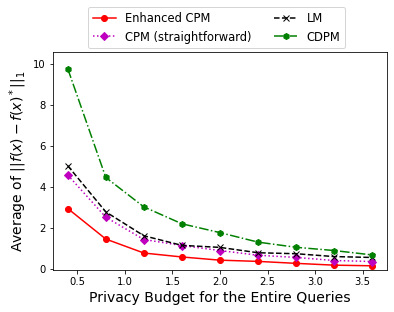

In [8]:
k = 2; m = [0,0,0]
run = 50
e = np.zeros((run,k+1))
for j in range(run):
    e[j] = [random.uniform(1,2) for l in range(k+1)]
    e[j][0] = 0


diff = evaluation(m,e,run)
print(diff)

s = [0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6]
fig = plt.figure()
plt.ylim(-0.03, max([max(diff[:,j]) for j in range(4)])+0.8)
plt.plot(s,diff[:,4],marker="o",color="red",linestyle = "-",label="Enhanced CPM")
#plt.plot(s,diff[:,3],marker="s",color="blue",linestyle = "dashed",label="Heuristic")
plt.plot(s,diff[:,0],marker="D",color="m",linestyle = "dotted",label="CPM (straightforward)")
plt.plot(s,diff[:,1],marker="x",color="black",linestyle = "dashed",label="LM")
plt.plot(s,diff[:,2],marker="h",color="green",linestyle = "dashdot",label="CDPM")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=11.5)
plt.xlabel("Privacy Budget for the Entire Queries",fontsize=14)
plt.ylabel("Average of $||f(x) - f(x)^*||_1$",fontsize=14)
fig.savefig("Accuracy_multiple_m=0_smallerEpsilon.png")
fig.savefig("figs/Accuracy_multiple_m=0_smallerEpsilon.eps", bbox_inches="tight", pad_inches=0.05)